# Feature selection based on Aris' methods

After removing features based on variance and joining correlated features, the final step of feature selection is to apply classical methods of feature selection. This will be done based on Aris' script.

## Load input files

- Input dataframe containing original features and target variable
- Importance scores of different methods

In [68]:
#Turn off scientific notation
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import numpy as np
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.2f}'.format})

#Activate print all activities
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [71]:
import sys
import pickle
import zstandard
import pandas as pd
import numpy as np
import datetime

#Load original dataframe

path = '../join_highly_correlated/chosen_files/'

folder = 'df_salt_kmer9Regression'

#file = path + 'df_salt_kmer9Classification_0.9000000000000001.pickle.zst'
file = path + folder + '_0.9500000000000002.pickle.zst'

#Define target group:
#group = 'Salinity group'
group = 'Salt all mean'
#group = 'Temp group'
#group = 'Temp all mean'
#group = 'pH all mean'
#group = 'Oxygen tolerance'

with zstandard.open(file, 'rb') as f:
	df = pickle.load(f)

df.head()

,CorGroup_AAAAAAAAC,CorGroup_GCAAAAAAA,CorGroup_AAAAAAACC,CorGroup_AAAAAACGG,CorGroup_GCAAAAACA,CorGroup_AAAAAACCG,CorGroup_AAAAAACGC,CorGroup_CAAAAACAA,CorGroup_AAAAAGGGA,CorGroup_AAAAAAGCC,...,CorGroup_TTGCGCAAA,TTGCGCCAA,CorGroup_TGAGCAAAA,CorGroup_TGGAACAAA,TTGGCCAAA,CorGroup_TAAAGCCAA,CorGroup_TTGGGCAAA,CorGroup_TGGTCAAAA,CorGroup_AAAACCAAT,Salt all mean
Best assembly,,,,,,,,,,,,,,,,,,,,,
1006155.5,87,189,80,101,168,52,115,238,122,152,...,89,72,54,87,49,73,23,79,132,32.50
1051501.5,146,273,229,207,188,205,214,217,179,278,...,59,49,95,79,57,73,33,69,117,65.00
1077675.3,210,283,92,90,124,44,87,285,129,150,...,39,61,88,144,36,77,44,89,198,65.00
1116389.3,4,17,11,10,31,19,16,27,20,39,...,42,80,23,12,46,14,44,40,20,10.00
111802.3,1,0,1,1,2,4,6,3,2,7,...,3,8,5,4,0,2,1,3,1,15.00


In [100]:
#method = 'tree_based'
method = 'L2'

#Load importance scores
folder2 = '../feature_selection/' + folder + '/'
file2 = folder2 + 'Importance_scores_' + method + '_abiotic_factors.tsv'

df_scores = pd.read_csv(file2, sep = '\t')
df_scores = df_scores.sort_values(by='Importance_score', ascending=False)

df_scores.head()

,Feature,Importance_score
9383,CorGroup_TGGATGAAA,9383
9382,CorGroup_CATCCTCGG,9382
9381,CorGroup_GGTTTTCAA,9381
9380,CorGroup_CCGATCAGG,9380
9379,CACCTGATC,9379


# Save files with different number of features

In [79]:
print('Method: ', method)

#Loop to get the top scored features from 50 to 300
for i in range(50, 301, 50):  
    
    #Get the top 'i' rows
    top_feat = df_scores.head(i)['Feature'].tolist()
    
    #Get a subset of a dataframe with columns matchin ids from top_feat
    df_subset = df[top_feat]

    #Add the target column of df to df_subset
    last_col = df.iloc[:, -1]
    df_subset = pd.concat([df_subset, last_col], axis=1)
    
    #df_subset.head()
    df_subset.shape

    df_subset.to_csv(folder2 + 'df_' + method + str(i) + '.csv', index=True) 

Method:  L2


(3418, 51)

(3418, 101)

(3418, 151)

(3418, 201)

(3418, 251)

(3418, 301)

# Benchmark

In [80]:
#Importing packages
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sys

## Classification

In [54]:
#CLASSIFICATION #########################################

#Based on: Benchmark of "remove_zero-variance.ipynb"

#Cross-validation packages
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import statistics
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

n_jobs = 5
f1_df = pd.DataFrame()

print("Started script on: ", datetime.datetime.now())
print('Method: ', method)

#Loop for different number of features
#for i in range(0, 301, 50):  
for i in range(50, 301, 50):      

    if(i == 0):
        i = 'no filter'
        tmp = df
    else:
        tmp = pd.read_csv(folder2 + 'df_' + method + str(i) + '.csv', index_col = 0) 
    
    print('Calculating metrics for threshold', i, 'of filtering low-variance features...')
    print('  Shape of input data:', tmp.shape)
    
    list_means = []

    #Separating features from group/target variable
    X = tmp.drop(group, axis=1)
    y = tmp[group]

    #I included random_state to make this command reproducible
    #Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    X, X_test, y, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, shuffle=True, random_state = 99)
    
    #UNDERSAMPLING has already been done in the variance filtering!
    
    print('  Shape of training data:', X.shape)
    
    #Do 10 iterations for every different threshold
    for it in range(1, 11, 1):
#    for it in range(1, 3, 1):        

        #Cross-validation with seed that changes with every iteration. The same split is desired per thresholds, since I want to
        # compare them. However within iterations, I want different splits
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=it)
        #I ran salt, gene-families without seed, and the results were extremely similar
    
        #Instantiate Random Forest model
        clf = RandomForestClassifier()

        scoring = ['f1']
        output = cross_validate(clf, X, y, cv=5, scoring = scoring, return_train_score=False, return_estimator =True, n_jobs=n_jobs)
        #print(output)
        #{'fit_time': array([0.68, 0.73, 0.72, 0.68, 0.61]), 'score_time': array([0.12, 0.11, 0.11, 0.19, 0.11]), 
        #'estimator': [RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier()], 
        #'test_f1': array([0.91, 0.90, 0.88, 0.75, 0.68])}
        
        #Get mean F1 for this iteration
        mean = statistics.mean(output['test_f1'])
        #Add mean F1 to vector containing results of all iterations
        list_means.append(mean)

        print(' Iteration', it, 'has as mean F1 value =', round(mean, 3), 'All values:', output['test_f1'])
    
    print(' Mean F1 score of cross-validation for all iterations:', round(statistics.mean(list_means), 3))
    print("Finished 10 iterations on: ", datetime.datetime.now())
    
    #Add new values
    f1_df[i] = list_means

Started script on:  2024-10-29 11:34:10.669660
Method:  tree_based
Calculating metrics for threshold 50 of filtering low-variance features...
  Shape of input data: (932, 51)
  Shape of training data: (745, 50)
 Iteration 1 has as mean F1 value = 0.764 All values: [0.79 0.79 0.80 0.70 0.75]
 Iteration 2 has as mean F1 value = 0.761 All values: [0.80 0.79 0.79 0.70 0.72]
 Iteration 3 has as mean F1 value = 0.76 All values: [0.77 0.76 0.81 0.72 0.73]
 Iteration 4 has as mean F1 value = 0.766 All values: [0.76 0.79 0.80 0.73 0.75]
 Iteration 5 has as mean F1 value = 0.762 All values: [0.79 0.80 0.76 0.72 0.73]
 Iteration 6 has as mean F1 value = 0.752 All values: [0.78 0.76 0.77 0.71 0.74]
 Iteration 7 has as mean F1 value = 0.765 All values: [0.75 0.79 0.78 0.74 0.75]
 Iteration 8 has as mean F1 value = 0.765 All values: [0.81 0.79 0.78 0.70 0.74]
 Iteration 9 has as mean F1 value = 0.767 All values: [0.77 0.80 0.79 0.72 0.75]
 Iteration 10 has as mean F1 value = 0.772 All values: [0.79 

## Regression

In [81]:
#REGRESSION #########################################

#Based on: Benchmark of "remove_zero-variance.ipynb/py"

#Importing packages
import pickle
import zstandard
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sys

#Cross-validation packages
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import statistics
from sklearn.ensemble import RandomForestRegressor


#REGRESSION #########################################

#For different scoring of cross_validate, check: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter "Regression"
#For the output of cross_validate: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

n_jobs = 5
f1_df = pd.DataFrame()

print("Started script on: ", datetime.datetime.now())
print('Method: ', method)

#Loop for different number of features
#for i in range(0, 301, 50):  
for i in range(50, 301, 50):      

    if(i == 0):
        i = 'no filter'
        tmp = df
    else:
        tmp = pd.read_csv(folder2 + 'df_' + method + str(i) + '.csv', index_col = 0) 
    
    print('Calculating metrics for threshold', i, 'of filtering low-variance features...')
    print('  Shape of input data:', tmp.shape)
    
    list_means = []

    #Separating features from group/target variable
    X = tmp.drop(group, axis=1)
    y = tmp[group]

    #I included random_state to make this command reproducible for after feature selection
    #Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 99)

    print('  Shape of training data:', X_train.shape)
    
    #Do 10 iterations for every different threshold
    for it in range(1, 11, 1):   

        #Cross-validation
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=it)
        #Instantiate Random Forest model
        clf = RandomForestRegressor()

        scoring = 'neg_mean_absolute_error'
        output = cross_validate(clf, X_train, y_train, cv=5, scoring=scoring, return_train_score=False, return_estimator=True, n_jobs=15)
        #print(output)
        #{'fit_time': array([57.96, 62.67, 56.21, 67.85, 60.65]), 'score_time': array([0.05, 0.05, 0.05, 0.05, 0.05]), 
        #'estimator': [RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor()], 
        #'test_score': array([-13.17, -12.15, -17.07, -19.26, -32.13])}

        #Get mean MAE for this iteration
        mean = statistics.mean(output['test_score'])
        #Add mean MAE to vector containing results of all iterations
        list_means.append(mean)

        print(' Iteration', it, 'has as mean absolute error =', round(mean, 3), 'All errors:', output['test_score'])
    
    print(' Mean absolute error of cross-validation for all iterations:', round(statistics.mean(list_means), 3))

    #Add new values
    f1_df[i] = list_means
    
    #Save benchmark results to a CSV file
#    f1_df.to_csv(path + 'mae_benchmark_' + abiotic_factor + '_' + feature + '.csv', index=True)

#Save benchmark results to a CSV file
#f1_df.to_csv(path + 'mae_benchmark_' + abiotic_factor + '_' + feature + '.csv', index=True)

Started script on:  2024-10-29 16:03:55.208171
Method:  L2
Calculating metrics for threshold 50 of filtering low-variance features...
  Shape of input data: (3418, 51)
  Shape of training data: (2734, 50)
 Iteration 1 has as mean absolute error = -20.175 All errors: [-19.01 -20.12 -20.30 -20.75 -20.69]
 Iteration 2 has as mean absolute error = -19.976 All errors: [-18.95 -19.80 -19.95 -20.56 -20.62]
 Iteration 3 has as mean absolute error = -20.136 All errors: [-19.00 -20.10 -19.96 -20.64 -20.98]
 Iteration 4 has as mean absolute error = -20.064 All errors: [-18.68 -20.22 -19.91 -20.66 -20.85]
 Iteration 5 has as mean absolute error = -20.024 All errors: [-18.91 -19.99 -19.99 -20.48 -20.76]
 Iteration 6 has as mean absolute error = -19.948 All errors: [-18.68 -20.02 -20.07 -20.24 -20.72]
 Iteration 7 has as mean absolute error = -19.941 All errors: [-18.86 -19.98 -20.03 -20.15 -20.68]
 Iteration 8 has as mean absolute error = -20.06 All errors: [-18.92 -20.05 -20.23 -20.39 -20.70]
 Ite

## Save metrics

In [82]:
#file_out_filtered

print('Method: ', method)

#Save benchmark results to a CSV file
#f1_df.to_csv(folder2 + 'df_' + method + '_F1_benchmarking.csv', index=True)
f1_df.to_csv(folder2 + 'df_' + method + '_MAE_benchmarking.csv', index=True)

Method:  L2


# Plot

In [96]:
method = 'tree_based'
#method = 'L2'

In [97]:
import pandas as pd

print('Method: ', method)

file_plot = folder2 + 'df_' + method

#Classification:
#file_metrics = file_plot + '_F1_benchmarking.csv'
#Regression:
file_metrics = file_plot + '_MAE_benchmarking.csv'

figure = folder2 + method + '.png'

# Load CSV data into a DataFrame
f1_df = pd.read_csv(file_metrics, index_col = 0)

f1_df.head()

Method:  tree_based


,50,100,150,200,250,300
0,-20.02,-19.63,-19.40,-19.37,-18.94,-18.90
1,-20.14,-19.56,-19.29,-19.39,-19.00,-18.93
2,-20.04,-19.61,-19.30,-19.22,-19.04,-18.88
3,-20.06,-19.58,-19.42,-19.40,-19.02,-18.94
4,-19.97,-19.67,-19.31,-19.30,-18.99,-18.90


../feature_selection/df_salt_kmer9Regression/tree_based.png


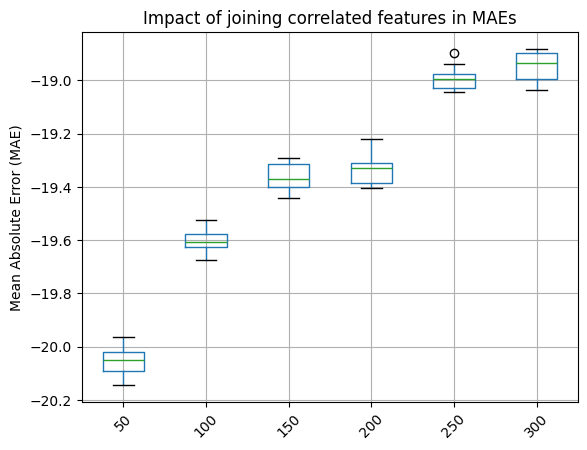

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

#Plot results 

#ADAPT THE LABELS FOR REGRESSION/CLASSIFICATION
#Plot the metrics for the cross-validation

boxplot = f1_df.boxplot();

#Add axis labels and title
plt.ylabel('F1 scores');
plt.ylabel('Mean Absolute Error (MAE)');
#plt.title('Impact of joining correlated features in F1 scores');
plt.title('Impact of joining correlated features in MAEs');
#plt.xlabel('Spearman correlation value for joining features');

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)
ticks = plt.xticks()[0]
labels = [str(round(float(label), 1)) for label in ticks]  # Round each label to 3 decimal places

plt.savefig(figure, dpi=300, bbox_inches='tight')
print(figure)

#Show plot
plt.show();